In [1]:
import numpy as np
import os
import copy
import pickle
import heapq
import matplotlib.pyplot as plt
from preprocessing_helper import *

In [2]:
cwd = os.getcwd()
parent_wd = cwd.replace('/preprocessing', '')
raw_data_path = parent_wd + '/preprocessing/processed_data_deltaxy_mode'  
url_data_path = parent_wd + '/raw_data/moonGen_scrape_2016_cp'

In [3]:
with open(url_data_path, 'rb') as f:
    MoonBoard_2016_withurl = pickle.load(f)

In [4]:
####################
# Input hold information & load moonboard problem
####################
#raw_data_path1 = "MoonBoardRNN/raw_data/moonGen_scrape_2016_cp"  ### raw Data
#raw_data_path = "MoonBoardRNN/raw_data/processed_data_xy_mode"
with open(raw_data_path, 'rb') as f:
    MoonBoard_2016_raw = pickle.load(f)
"""
    Input:
    - xy_mode_processed_data: 
      if set False(default), the x_vector compiled will be of shape (10, n_holds) (6 hold features, x, y, is_start, is_end)
      if set True, the x_vector compiled will be of shape (14, n_holds) (6 hold features, x, y, dx1, dy1, dx2, dy2, is_start, is_end)
    
    Classify and process the raw data into 4 caterogies/8 dictionaries:
    - X_dict_benchmark_withgrade: the input data that is benchmarked and contains user grading.
    - Y_dict_benchmark_withgrade: the output for raw data that is benchmarked and contains user grading.
    - X_dict_benchmark_nograde: the input data that is benchmarked and does not contain user grading.
    - Y_dict_benchmark_nograde: the output for raw data that is benchmarked and does not contain user grading.
    - X_dict_withgrade: the input data that is not benchmarked and contains user grading.
    - Y_dict_withgrade: the output for raw data that is not benchmarked and contains user grading.
    - X_dict_nograde: the input data that is not benchmarked and does not contain user grading.
    - Y_dict_nograde: the output for raw data that is not benchmarked and does not contain user grading.
    For the ones that do not have user grading, the shape of each item in Y_dict is (2, 1): (grade, is_benchmarked)
    For the ones that have user grading, the shape of each item in Y_dict is (3, 1): (grade, is_benchmarked, user_grade)
"""    

'\n    Input:\n    - xy_mode_processed_data: \n      if set False(default), the x_vector compiled will be of shape (10, n_holds) (6 hold features, x, y, is_start, is_end)\n      if set True, the x_vector compiled will be of shape (14, n_holds) (6 hold features, x, y, dx1, dy1, dx2, dy2, is_start, is_end)\n    \n    Classify and process the raw data into 4 caterogies/8 dictionaries:\n    - X_dict_benchmark_withgrade: the input data that is benchmarked and contains user grading.\n    - Y_dict_benchmark_withgrade: the output for raw data that is benchmarked and contains user grading.\n    - X_dict_benchmark_nograde: the input data that is benchmarked and does not contain user grading.\n    - Y_dict_benchmark_nograde: the output for raw data that is benchmarked and does not contain user grading.\n    - X_dict_withgrade: the input data that is not benchmarked and contains user grading.\n    - Y_dict_withgrade: the output for raw data that is not benchmarked and contains user grading.\n    -

### display the Gaussian distance plot

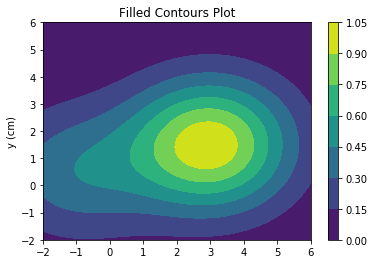

In [5]:
xlist = np.linspace(-2,6, 100)
ylist = np.linspace(-2,6, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = makeGaussian((X,Y), 4, (0,0))
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

### Define Current Status

In [5]:
output = produce_sequence(keyNum = '337509', X_dict = MoonBoard_2016_raw["X_dict_benchmark_withgrade"], n_return = 1)

After Beamer search, the most possible hand sequence and the successRate:
[0, 0, 1, 2, 3, 4, 5] ['LH', 'RH', 'LH', 'RH', 'LH', 'RH', 'LH'] 229.17442900816357
[13.966610165238235, 3.771272258651297, 3.462239147685987, 4.2965295841566284, 1.0226156288345547, 9.826095003804213, 40.82321619767785]


In [6]:
keyNum = "337509"    
#moonboardTest = (MoonBoard_2016_raw["X_dict_benchmark_withgrade"])["102018"]
#moonboardTest = (MoonBoard_2016_raw["X_dict_benchmark_withgrade"])["337509"]
#moonboardTest = (MoonBoard_2016_raw["X_dict_benchmark_withgrade"])["332721"]
moonboardTest = (MoonBoard_2016_raw["X_dict_benchmark_withgrade"])[keyNum]


In [7]:
testbeta = beta(moonboardTest.T)
status = [beta(moonboardTest.T), beta(moonboardTest.T)]
print("keyNum = ", keyNum)
print(status[0].allHolds)
moonboardTestUrl = MoonBoard_2016_withurl[keyNum]
print(moonboardTestUrl["url"])
# Initialized Start hold of two different beta
status[0].addStartHolds(0)
status[1].addStartHolds(1)

operationList = ["RH", "LH"]
tempstatus = []
tempstatus2 = []
tempstatus3 = []
distanceScore = []

keyNum =  337509
[[ 0.  2.  5.  2.  0.  0. 10.  4.  1.  0.]
 [ 2.  5.  2.  0.  0.  0.  5.  6.  0.  0.]
 [ 0.  1.  4.  1.  0.  0.  8. 10.  0.  0.]
 [ 1.  5.  3.  1.  0.  0.  5. 13.  0.  0.]
 [ 2.  3.  4.  2.  1.  0.  3. 16.  0.  0.]
 [ 3.  7.  5.  2.  0.  0.  1. 17.  0.  1.]]
https://moonboard.com/Problems/View/337509/pixel-bricks


In [16]:
# Run the algorithm for 6 times
totalRun = status[0].totalNumOfHold - 1
for i in range(totalRun):  # how many new move you wan to add
    status = addNewBeta(status, printOut = False)
    finalScore = [] 
    for i in status:   
        finalScore.append(i.overallSuccessRate())
    largestIndex = heapq.nlargest(4, range(len(finalScore)), key=finalScore.__getitem__)
    if (status[largestIndex[0]].isFinished and status[largestIndex[1]].isFinished) == True:
        break

In [17]:
# last sorting for the best 5
finalScore = [] 
print(status)
for i in status:   
    finalScore.append(i.overallSuccessRate())   
largestIndex = heapq.nlargest(1, range(len(finalScore)), key=finalScore.__getitem__)

[<preprocessing_helper.beta object at 0x123e65ed0>, <preprocessing_helper.beta object at 0x123e65a50>, <preprocessing_helper.beta object at 0x123e8b750>, <preprocessing_helper.beta object at 0x123e8b9d0>, <preprocessing_helper.beta object at 0x123e8be50>, <preprocessing_helper.beta object at 0x123e8b1d0>, <preprocessing_helper.beta object at 0x123e8b8d0>, <preprocessing_helper.beta object at 0x123e87d10>]


In [18]:
print(moonboardTestUrl["url"])
print ("After Beamer search, the most possible hand sequence and the successRate:")
for i in largestIndex:
    
    print(status[i].handSequence, status[i].handOperator, status[i].overallSuccessRate())
    print(status[i].successScoreSequence)


https://moonboard.com/Problems/View/337509/pixel-bricks
After Beamer search, the most possible hand sequence and the successRate:
[0, 0, 1, 2, 3, 4, 5] ['LH', 'RH', 'LH', 'RH', 'LH', 'RH', 'LH'] 229.17442900816357
[13.966610165238235, 3.771272258651297, 3.462239147685987, 4.2965295841566284, 1.0226156288345547, 9.826095003804213, 40.82321619767785]
